In [1]:
import os
import re
import sys
from collections import Counter
from itertools import islice
from urllib.parse import urlparse, urlsplit, parse_qs, parse_qsl

import numpy as np
import parsel
import sklearn_crfsuite
from sklearn_crfsuite.metrics import flat_classification_report, sequence_accuracy_score
from sklearn.model_selection import cross_val_predict, GroupKFold

sys.path.insert(0, '..')
from autopager.storage import Storage
from autopager.htmlutils import (get_link_text, get_text_around_selector_list,
                                 get_link_href, get_selector_root)
from autopager.utils import (
    get_domain, normalize_whitespaces, normalize, ngrams, tokenize, ngrams_wb, replace_digits
)
from autopager.model import link_to_features, _num_tokens_feature, _elem_attr
from autopager import AUTOPAGER_LIMITS
storage = Storage()

../autopager/data


In [2]:
urls = [rec['Page URL'] for rec in storage.iter_records(contain_button = True, file_type='T')]
X_raw, y = storage.get_Xy(contain_button = True, file_type='T')
print("pages: {}  domains: {}".format(len(urls), len({get_domain(url) for url in urls})))

Finish: Get Page 1 (Encoding: UTF-8)records ... (len: 303)
Finish: Get Page 2 (Encoding: UTF-8)records ... (len: 243)
Finish: Get Page 3 (Encoding: UTF-8)records ... (len: 119)
Finish: Get Page 4 (Encoding: UTF-8)records ... (len: 944)
Finish: Get Page 5 (Encoding: UTF-8)records ... (len: 93)
Finish: Get Page 6 (Encoding: UTF-8)records ... (len: 994)
Finish: Get Page 7 (Encoding: UTF-8)records ... (len: 1014)
Finish: Get Page 8 (Encoding: UTF-8)records ... (len: 7)
Finish: Get Page 9 (Encoding: UTF-8)records ... (len: 288)
Finish: Get Page 10 (Encoding: UTF-8)records ... (len: 678)
Finish: Get Page 11 (Encoding: UTF-8)records ... (len: 789)
Finish: Get Page 12 (Encoding: UTF-8)records ... (len: 814)
Finish: Get Page 13 (Encoding: UTF-8)records ... (len: 814)
Finish: Get Page 14 (Encoding: UTF-8)records ... (len: 171)
Finish: Get Page 15 (Encoding: UTF-8)records ... (len: 168)
Finish: Get Page 16 (Encoding: UTF-8)records ... (len: 91)
Finish: Get Page 17 (Encoding: UTF-8)records ... (le

Finish: Get Page 161 (Encoding: UTF-8)records ... (len: 101)
Finish: Get Page 162 (Encoding: UTF-8)records ... (len: 279)
Finish: Get Page 163 (Encoding: UTF-8)records ... (len: 269)
Finish: Get Page 164 (Encoding: UTF-8)records ... (len: 259)
Finish: Get Page 165 (Encoding: UTF-8)records ... (len: 133)
Finish: Get Page 166 (Encoding: UTF-8)records ... (len: 181)
Finish: Get Page 167 (Encoding: UTF-8)records ... (len: 94)
Finish: Get Page 168 (Encoding: UTF-8)records ... (len: 99)
Finish: Get Page 169 (Encoding: UTF-8)records ... (len: 103)
Finish: Get Page 170 (Encoding: UTF-8)records ... (len: 210)
Finish: Get Page 171 (Encoding: UTF-8)records ... (len: 208)
Finish: Get Page 172 (Encoding: UTF-8)records ... (len: 179)
Finish: Get Page 173 (Encoding: UTF-8)records ... (len: 461)
Finish: Get Page 174 (Encoding: UTF-8)records ... (len: 340)
Finish: Get Page 175 (Encoding: UTF-8)records ... (len: 188)
Finish: Get Page 176 (Encoding: UTF-8)records ... (len: 195)
Finish: Get Page 177 (Enco

Finish: Get Page 308 (Encoding: UTF-8)records ... (len: 60)
Finish: Get Page 309 (Encoding: UTF-8)records ... (len: 145)
Finish: Get Page 310 (Encoding: UTF-8)records ... (len: 116)
Finish: Get Page 311 (Encoding: UTF-8)records ... (len: 119)
Finish: Get Page 312 (Encoding: cp1252)records ... (len: 136)
Finish: Get Page 313 (Encoding: UTF-8)records ... (len: 383)
Finish: Get Page 314 (Encoding: UTF-8)records ... (len: 317)
Finish: Get Page 315 (Encoding: cp1252)records ... (len: 314)
Finish: Get Page 316 (Encoding: cp1252)records ... (len: 357)
Finish: Get Page 317 (Encoding: cp1252)records ... (len: 370)
Finish: Get Page 318 (Encoding: UTF-8)records ... (len: 137)
Finish: Get Page 319 (Encoding: UTF-8)records ... (len: 281)
Finish: Get Page 320 (Encoding: UTF-8)records ... (len: 281)
Finish: Get Page 321 (Encoding: UTF-8)records ... (len: 247)
Finish: Get Page 322 (Encoding: UTF-8)records ... (len: 248)
pages: 320  domains: 107


## Use href as feature

In [23]:
%%time
# XXX: these functions should be copy-pasted from autopager/model.py

def _as_list(generator, limit=None):
    """
    >>> _as_list(ngrams_wb("text", 2, 2), 0)
    []
    >>> _as_list(ngrams_wb("text", 2, 2), 2)
    ['te', 'ex']
    >>> _as_list(ngrams_wb("text", 2, 2))
    ['te', 'ex', 'xt']
    """
    return list(generator if limit is None else islice(generator, 0, limit))


def link_to_features(link):
    text = normalize(get_link_text(link))
    href = get_link_href(link)
    if href is None:
        href = ""
    p = urlsplit(href)
    query_parsed = parse_qsl(p.query) #parse query string from path
    query_param_names = [k.lower() for k, v in query_parsed]
    query_param_names_ngrams = _as_list(ngrams_wb(
        " ".join([normalize(name) for name in query_param_names]), 3, 5, True
    ))

    elem = get_selector_root(link)
    elem_target = _elem_attr(elem, 'target')
    elem_rel = _elem_attr(elem, 'rel')
    # Classes of link itself and all its children.
    # It is common to have e.g. span elements with fontawesome
    # arrow icon classes inside <a> links.
    self_and_children_classes = ' '.join(link.xpath(".//@class").extract())
    parent_classes = ' '.join(link.xpath('../@class').extract())
    css_classes = normalize(parent_classes + ' ' + self_and_children_classes)

    return {
#         'bias': 3.0,
#         'isdigit': text.isdigit(),
#         'isalpha': text.isalpha(),
#         'elem-target': elem_target,
#         'elem-rel': elem_rel,
#         'num-tokens%s' % _num_tokens_feature(text): 1.0,

#         'text': _as_list(ngrams_wb(replace_digits(text), 2, 5),
#                          AUTOPAGER_LIMITS.max_text_features),
        'text-exact': replace_digits(text.strip()[:20].strip()),
#         'class': _as_list(ngrams_wb(css_classes, 4, 5),
#                           AUTOPAGER_LIMITS.max_css_features),
#         'query': query_param_names_ngrams,
#         'has-href': False if href is "" else True,
#         'path-has-page': 'page' in p.path.lower(),
#         'path-has-pageXX': re.search(r'[/-](?:p|page\w?)/?\d+', p.path.lower()) is not None,
#         'path-has-number': any(part.isdigit() for part in p.path.split('/')),

#         'href-has-year': re.search('20\d\d', href) is not None,
#         'href-had-self-redirection': '#' in href
    }


def page_to_features(xseq):
    features = [link_to_features(a) for a in xseq]
    around = get_text_around_selector_list(xseq, max_length=15)

    # weight is less than 1 because there is a lot of duplicate information
    # in these ngrams and so we want to regularize them stronger
    # (as if they are a single feature, not many features)
#     k = 0.2
#     for feat, (before, after) in zip(features, around):
#         feat['text-before'] = {n: k for n in _as_list(ngrams_wb(normalize(before), 5, 5))}
#         feat['text-after'] = {n: k for n in _as_list(ngrams_wb(normalize(after), 5, 5))}
    return features

CPU times: user 19 µs, sys: 0 ns, total: 19 µs
Wall time: 21 µs


In [113]:
X_raw[0][30]

'<a href="https://forums.oneplus.com/categories/products.168/">\n\t\t\t\t\t<span>Products</span>\n\t\t\t\t</a>'

In [52]:
get_selector_root(X_raw[0][30]).get("href",'')

'https://forums.oneplus.com/categories/products.168/'

In [53]:
get_link_href(X_raw[0][30])

'https://forums.oneplus.com/categories/products.168/'

In [104]:
page_appear = []
last_page_appear = []
for page in y:
    page_size = len(page)
    for i in range(page_size):
        if page[i] == 'PAGE' or page[i] == 'NEXT':
            first_PAGE = i/page_size
            page_appear.append(first_PAGE)
    for j in range(page_size-1,-1,-1):
        if page[j] == 'PAGE' or page[j] == 'NEXT':
            last_PAGE = j/page_size
            last_page_appear.append(last_PAGE)
            break
print(len(page_appear))
print(len(last_page_appear))
# first_page_appear.extend(last_page_appear)

2176
221


In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

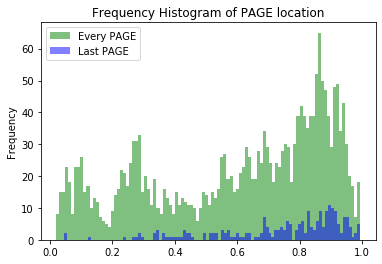

In [110]:
kwargs = dict(alpha=0.5, bins=100)
plt.hist(page_appear, **kwargs, color='g', label='Every PAGE')
plt.hist(last_page_appear, **kwargs, color='b', label='Last PAGE')
plt.gca().set(title='Frequency Histogram of PAGE location', ylabel='Frequency')
plt.legend();

In [24]:
X = [page_to_features(xseq) for xseq in X_raw]

## Not use href as feature

In [6]:
groups = [get_domain(url) for url in urls]

In [7]:
groups

['oneplus',
 'oneplus',
 'oneplus',
 'sheetmusicplus',
 'oneplus',
 'sheetmusicplus',
 'sheetmusicplus',
 'leetcode',
 'civfanatics',
 'mobile01',
 'mobile01',
 'mobile01',
 'mobile01',
 'binarymarket',
 'binarymarket',
 'michelson',
 'michelson',
 'michelson',
 'michelson',
 'route41',
 'trioplast',
 'icontact',
 'icontact',
 'allmonitors',
 'rumorfix',
 'rumorfix',
 'chinatimes',
 'safarinow',
 'gov',
 'gov',
 'gov',
 'gov',
 'tomandlorenzo',
 'tomandlorenzo',
 'tomandlorenzo',
 'barnesandnoble',
 'barnesandnoble',
 'barnesandnoble',
 'ptt',
 'ncu',
 'askdin',
 'askdin',
 'juragancipir',
 'juragancipir',
 'juragancipir',
 'citysquares',
 'citysquares',
 'noobmeter',
 'noobmeter',
 'themestotal',
 'debijenkorf',
 'tripadvisor',
 'zoover',
 'notebooksbilliger',
 'notebooksbilliger',
 'jwpepper',
 'jwpepper',
 'zone-concours',
 'zone-concours',
 'astral-guild',
 'astral-guild',
 'flyordie',
 'flyordie',
 'flyordie',
 'mindfactory',
 'mindfactory',
 'mindfactory',
 'playrust',
 'themusic

In [25]:
# TRAIN_SIZE = 80
# X_train, y_train = X[:TRAIN_SIZE], y[:TRAIN_SIZE]
# X_test, y_test = X[TRAIN_SIZE:], y[TRAIN_SIZE:]
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.001,
    c2=0.05,
    max_iterations=100,
    all_possible_transitions=True,
    verbose=True,
)
# crf.fit(X_train, y_train, X_test, y_test)

In [26]:
crf

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.001, c2=0.05,
    keep_tempfiles=None, max_iterations=100, verbose=True)

We must be careful when splitting the dataset into training and
evaluation parts: pages from the same domain should be in the same
"bin". There could be several pages from the same domain, and these
pages may have duplicate or similar link patterns
(e.g. a particular CSS class for paginator links). If we put one such page in a training dataset and another in
an evaluation dataset then the metrics will be too optimistic,
and they can make us to choose wrong features/models.

In [10]:
%%time
group_kfold = GroupKFold(n_splits=6)
groups = [get_domain(url) for url in urls]
y_pred = cross_val_predict(crf, X, y, cv=group_kfold, groups=groups, n_jobs=-1)
print(flat_classification_report(y, y_pred, labels=['PAGE', 'NEXT', 'PREV'], digits=3))
print("Sequence accuracy: {:0.3f}".format(sequence_accuracy_score(y, y_pred)))

/home/sam/DL/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=['PAGE', 'NEXT', 'PREV'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


              precision    recall  f1-score   support

        PAGE      0.787     0.840     0.812      1929
        NEXT      0.853     0.773     0.811       247
        PREV      0.627     0.715     0.668       179

   micro avg      0.780     0.823     0.801      2355
   macro avg      0.756     0.776     0.764      2355
weighted avg      0.782     0.823     0.801      2355

Sequence accuracy: 0.591
CPU times: user 1min 52s, sys: 3.75 s, total: 1min 56s
Wall time: 2min 18s


In [27]:
crf.fit(X, y)
# crf.attributes_
crf.num_attributes_

loading training data to CRFsuite: 100%|██████████| 320/320 [00:00<00:00, 2428.50it/s]



Feature generation
type: CRF1d
feature.minfreq: 0.000000
feature.possible_states: 0
feature.possible_transitions: 1
0....1....2....3....4....5....6....7....8....9....10
Number of features: 21603
Seconds required: 0.024

L-BFGS optimization
c1: 0.001000
c2: 0.050000
num_memories: 6
max_iterations: 100
epsilon: 0.000010
stop: 10
delta: 0.000010
linesearch: MoreThuente
linesearch.max_iterations: 20

Iter 1   time=0.03  loss=42117.55 active=21601 feature_norm=1.00
Iter 2   time=0.01  loss=11731.27 active=21593 feature_norm=4.25
Iter 3   time=0.01  loss=11101.70 active=21592 feature_norm=4.11
Iter 4   time=0.06  loss=4641.11  active=21592 feature_norm=3.32
Iter 5   time=0.01  loss=3849.62  active=21594 feature_norm=4.59
Iter 6   time=0.01  loss=3778.15  active=21603 feature_norm=4.64
Iter 7   time=0.01  loss=3587.52  active=21601 feature_norm=4.61
Iter 8   time=0.01  loss=3395.39  active=21601 feature_norm=4.87
Iter 9   time=0.01  loss=3213.31  active=21601 feature_norm=5.54
Iter 10  time=

12238

In [15]:
crf.classes_

['O', 'PAGE', 'NEXT', 'PREV']

In [15]:
# [a for a in sorted(crf.attributes_) if a.startswith('id')]

## What are important features?

In [12]:
import eli5

/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/home/sam/DL/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


In [13]:
# XXX: weight for correlated features don't show their importance
# XXX: weights for features of different scale don't show their importance
# (e.g. coefficients to text-after and text-before features are high, but only
# because input is scaled down for these features)

eli5.show_weights(crf, top=50)

/home/sam/DL/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


## Let's check errors the model is making

In [39]:
group_kfold = GroupKFold(n_splits=6)
groups = [get_domain(url) for url in urls]
y_pred = cross_val_predict(crf, X, y, cv=group_kfold, groups=groups, n_jobs=-1)

errors = np.asarray(y) != np.asarray(y_pred)
error_rows = np.asarray(list(storage.iter_records(contain_button=True,file_type='T')))[errors]
error_links = np.asarray(X_raw)[errors]
error_y_pred = y_pred[errors]
error_y_true = np.asarray(y)[errors]

/home/sam/DL/lib/python3.6/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


In [52]:
error_rows

array([OrderedDict([('Checked', 'T'), ('File Name', '1'), ('Page URL', 'https://forums.oneplus.net/threads/marsh-cm13.405700/'), ('Page Type', 'a'), ('Encoding', 'UTF-8'), ('PREV', ''), ('PAGE', '.currentPage , .scrollable a'), ('NEXT', '.text'), ('LAST', '.PageNavNext+ a'), ('FIRST', ''), ('failed', '')]),
       OrderedDict([('Checked', 'T'), ('File Name', '2'), ('Page URL', 'https://forums.oneplus.net/threads/marsh-cm13.405700/page-5'), ('Page Type', 'a'), ('Encoding', 'UTF-8'), ('PREV', '.text:nth-child(1)'), ('PAGE', '.currentPage , .scrollable a'), ('NEXT', 'a+ .text'), ('LAST', '.PageNavNext+ a'), ('FIRST', '.text+ a'), ('failed', '')]),
       OrderedDict([('Checked', 'T'), ('File Name', '3'), ('Page URL', 'https://forums.oneplus.com/threads/marsh-cm13.405700/page-349'), ('Page Type', 'a'), ('Encoding', 'UTF-8'), ('PREV', '.text'), ('PAGE', '.currentPage , .scrollable a'), ('NEXT', ''), ('LAST', ''), ('FIRST', '.text+ a'), ('failed', '')]),
       OrderedDict([('Checked', 'T'),

In [50]:
y_pred

array([list(['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'PAGE', 'PAGE', 'PAGE', 'PAGE', 'PAGE', 'O', 'PAGE', 'NEXT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [51]:
test_y_pred

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'PAGE',
  'O',
  'NEXT',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O

In [43]:
errors

array([ True,  True,  True, False, False,  True, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False,  True,  True, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False,  True,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False,  True, False,  True,  True, False, False, False, False,
        True,  True, False,  True, False, False, False,  True, False,
        True, False,  True,  True, False,  True, False, False, False,
       False, False,

In [20]:
for links, yseq_pred, yseq_true, row in zip(error_links, error_y_pred, error_y_true, error_rows):
    print(row['Page URL'])
    for label_correct, label_pred, link in zip(yseq_true, yseq_pred, links.extract()):
        if label_correct != label_pred:
            print("CORRECT: %4s, PREDICT: %4s, LINK: %s" % (label_correct, label_pred, link))
    print("\n")

https://forums.oneplus.net/threads/marsh-cm13.405700/
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="currentPage " rel="start">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="currentPage " rel="start">1</a>


https://forums.oneplus.net/threads/marsh-cm13.405700/page-5
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="" rel="start">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="" rel="start">1</a>


https://forums.oneplus.com/threads/marsh-cm13.405700/page-349
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/" class="" rel="start">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/page-344" class="">344</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/page-345" class="">345</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="threads/marsh-cm13.405700/page-346" class="">346</a>
CO

## Unused code

In [25]:
def _url_parts(url):
    p = urlsplit(url)
    args = parse_qsl(p.query)
    argnames = [name for name, value in args]
    return p.netloc, set(p.path.split('/')) | set(args) | set(argnames)

def url_distance(url1, url2):
    netloc1, parts1 = _url_parts(url1)
    netloc2, parts2 = _url_parts(url2)
    if netloc1 != netloc2:
        return 1.0
    if not parts1 and not parts2:
        return 0.0
    return 1 - len(parts1 & parts2) / len(parts1 | parts2)

#         dist = url_distance(url, href)
#         if dist == 0:
#             feat['url-distance=0'] = 1.0
#         elif dist == 1.0:
#             feat['url-distance=1'] = 1.0
#         else:
#             feat['url-distance=k'] = dist


url_distance('http://example.com/foo/345?page=2', 'http://example.com/foo/345?page=4')

0.33333333333333337

In [26]:
# def guess_page_number(link):
#     text = get_link_text(link).strip()
#     if text.isdigit():
#         return int(text)
#     return None

# def number_pattern2(pattern):
#     txt = re.sub('X+', 'X', pattern)
# #     txt = re.sub('C+', 'C', txt)
#     return txt

#     pagenums = [guess_page_number(a) for a in xseq]
# #     print(pagenums)
#     for i in range(1, len(xseq)):
#         if pagenums[i-1] is None or pagenums[i] is None:
#             features[i]['page-diff:None'] = 1.0
#         else:
#             diff = pagenums[i] - pagenums[i-1]
#             if diff == 1:
#                 features[i]['page-diff==1'] = 1.0
#             else:
#                 features[i]['page-diff<>1'] = 1.0


# Test data

In [28]:
test_urls = [rec['url'] for rec in storage.iter_test_records()]
test_X_raw, test_y = storage.get_test_Xy()
print("pages: {}  domains: {}".format(len(test_urls), len({get_domain(url) for url in test_urls})))

pages: 21  domains: 13


In [29]:
test_X = [page_to_features(xseq) for xseq in test_X_raw]
test_y_pred = crf.predict(test_X)

In [30]:
errors = np.asarray(test_y) != np.asarray(test_y_pred)

In [31]:
test_y_pred = np.asarray(test_y_pred)

In [32]:
type(test_y_pred[0])

list

In [33]:
print(flat_classification_report(test_y, test_y_pred, labels=['PAGE', 'NEXT', 'PREV'], digits=3))

              precision    recall  f1-score   support

        PAGE      0.895     0.648     0.752       145
        NEXT      0.688     0.407     0.512        27
        PREV      0.500     0.462     0.480        13

   micro avg      0.835     0.600     0.698       185
   macro avg      0.694     0.506     0.581       185
weighted avg      0.837     0.600     0.698       185



In [20]:
errors = np.asarray(test_y) != np.asarray(test_y_pred)
error_rows = np.asarray(list(storage.iter_test_records()))[errors]
error_links = np.asarray(test_X_raw)[errors]
error_y_pred = test_y_pred[errors]
error_y_true = np.asarray(test_y)[errors]

In [21]:
errors

array([False, False,  True,  True,  True,  True, False,  True, False,
       False,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True])

In [22]:
for links, yseq_pred, yseq_true, row in zip(error_links, error_y_pred, error_y_true, error_rows):
    print(row['url'])
    for label_correct, label_pred, link in zip(yseq_true, yseq_pred, links.extract()):
        if label_correct != label_pred:
            print("CORRECT: %4s, PREDICT: %4s, LINK: %s" % (label_correct, label_pred, link))
    print("\n")

https://www.mobile01.com/topiclist.php?f=180
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180" class="c-pagination " data-page="1">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180&amp;p=30" class="c-pagination " data-page="30">30</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180" class="c-pagination " data-page="1">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180&amp;p=30" class="c-pagination " data-page="30">30</a>


https://www.mobile01.com/topiclist.php?f=180&p=4
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180" class="c-pagination " data-page="1">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180&amp;p=30" class="c-pagination " data-page="30">30</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180" class="c-pagination " data-page="1">1</a>
CORRECT: PAGE, PREDICT:    O, LINK: <a href="/topiclist.php?f=180&amp;p=30" class="c-pagination " data-page=

In [20]:
X_raw[0]

[<Selector xpath='.//a|.//button' data='<a href="https://www.oneplus.com"><im...'>,
 <Selector xpath='.//a|.//button' data='<a href="https://www.oneplus.com/8t">...'>,
 <Selector xpath='.//a|.//button' data='<a href="https://www.oneplus.com/stor...'>,
 <Selector xpath='.//a|.//button' data='<a href="https://www.oneplus.com/bran...'>,
 <Selector xpath='.//a|.//button' data='<a href="https://www.oneplus.com/supp...'>,
 <Selector xpath='.//a|.//button' data='<a class="active" href="/">Community</a>'>,
 <Selector xpath='.//a|.//button' data='<a href="https://www.oneplus.com/reta...'>,
 <Selector xpath='.//a|.//button' data='<a class="btn-collapsed js-pull-off-c...'>,
 <Selector xpath='.//a|.//button' data='<a href="//www.oneplus.com">Home</a>'>,
 <Selector xpath='.//a|.//button' data='<a href="javascript:;" class="js-exit...'>,
 <Selector xpath='.//a|.//button' data='<a href="//www.oneplus.com/8t">OnePlu...'>,
 <Selector xpath='.//a|.//button' data='<a href="//www.oneplus.com/store">Sto...

In [2]:
!python -V

Python 3.6.9
